In [131]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import time 
import json
import math

from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [9]:
def clean_target_predicted(target, predicted, remove_zeros = True):
    if isinstance(target, list):
        target = np.array(target)
    if isinstance(predicted, list):
        predicted = np.array(predicted)

    assert target.shape == predicted.shape, "Target and prediction don't have the same shape"
    assert isinstance(target, np.ndarray) and isinstance(predicted, np.ndarray), "Target and prediction should be list of numpy array"
    
    ## Removing zero observations in target data. 
    if remove_zeros:
        non_zeros = target != 0
        target = target[non_zeros]
        predicted = predicted[non_zeros]
    return target, predicted

In [10]:
def APE(target, predicted, remove_zeros = True):
    target, predicted = clean_target_predicted(target, predicted, remove_zeros)
    return np.abs((target - predicted) / target)

def MAPE(target, predicted):
    # target, predicted = clean_target_predicted(target, predicted)
    return np.mean(APE(target, predicted))

def MAAPE(target, predicted):
    ape = APE(target, predicted, remove_zeros = False)
    return np.mean(np.arctan(ape))

def VAPE(target, predicted):
    # target, predicted = clean_target_predicted(target, predicted)
    return np.var(APE(target, predicted))

def RMSE(target, predicted):
    target, predicted = clean_target_predicted(target, predicted)
    return np.sqrt(np.mean((target - predicted)**2))

In [21]:
def _evaluation_metrics(data, metrics):
    """ Evaluation metrics for predcition 
    Parameters:
    ------------
    - data: dict with resutls. 
    - metrics: list. List of evaluation metrics, input should be target, and prediction array"""

    station = data.pop('name')

    periods = ['pre', 'post']
    values = ['target', 'predict']
    # metrics = ['MAPE', 'MAAPE', 'VAPE']
    results = {}

    for period in periods: 
        for value in values: 
            name = period + "_" + value
            
            assert name in data.keys()

            if value == 'target':
                target = np.array(data[name])
            elif value =='predict':
                predicted = np.array(data[name])

        assert isinstance(target, np.ndarray)
        assert isinstance(predicted, np.ndarray)

        for metric in metrics: 
            name = period + "_" + metric
            expresion = metric + "(target, predicted)"
            results[name] = eval(expresion)

    # pre_predicted = np.array(data['pre_predict'])
    # pre_target = np.array(data['pre_target'])
    # post_predicted = np.array(data['post_predict'])
    # post_target = np.array(data['post_target'])

    # results = {}
    # results['pre_MAPE'] = MAPE(pre_target, pre_predicted)
    # results['pre_MAAPE'] = MAAPE(pre_target, pre_predicted)
    # results['pre_VAPE'] = VAPE(pre_target, pre_predicted)
    # # results['pre_RMSE'] = RMSE(pre_target, pre_predicted)
    # results['post_MAPE'] = MAPE(post_target, post_predicted)
    # results['post_MAAPE'] = MAAPE(post_target, post_predicted)
    # results['post_VAPE'] = VAPE(post_target, post_predicted)
    # # results['post_RMSE'] = RMSE(post_target, post_predicted)

    return station, results

In [36]:
def file_names(path):
    files = os.listdir(path)

    cable_stations = ['(40000) Cable Portal Tunal.json','(40001) Juan Pablo II.json', 
                    '(40002) Manitas.json', '(40003) Mirador del Paraiso.json', 'evaluation_metrics_summary.csv']

    files = list(set(files) - set(cable_stations))
    return files

In [80]:
def evaluation_metrics(path, metrics, overwrite = True):
    """ 
    Generates a dataframe with the evaluation metrics for all files in path
    parameters: 
    ------------
    - path: 'str'. Path to resutls files. 
    - metrics: 'list'. List of metrics to evalaute 
    
    returns:
    ----------
    - Pandas Dataframe, saves resutls in csv file in path 
    """ 
    file_name = path + '/evaluation_metrics_summary.csv'

    if (overwrite) | (not os.path.isfile(file_name)):
        files = file_names(path)

        results = {}
        for file in files: 
            path_file ='output/rnn/' + file
            with open(path_file) as f:
                data = json.load(f)
            station, metrics_result = _evaluation_metrics(data, metrics)
            results[station] = metrics_result
        
        df = pd.DataFrame.from_dict(results, orient = 'index')
        df.to_csv(path + '/evaluation_metrics_summary.csv')

    elif os.path.isfile(file_name):
        df = pd.read_csv(file_name, index_col = 0)

    return df 

In [120]:
def linear_regression(results, metrics):

    models_list = []

    for metric in metrics: 
        pre_name = 'pre_' + metric
        post_name = 'post_' + metric
        x = sm.add_constant(results[pre_name].rename('pre-COVID 19 metric'), prepend=False)
        model = sm.OLS(results[post_name], x).fit()
        models_list.append(model)

    ols_results = summary_col(models_list,stars=True, info_dict = {"N":lambda x:(x.nobs)},
                              model_names = metrics, float_format='%.3f')

    return ols_results

In [ ]:
def plot_results(results, metrics):

    cols = 2
    rows =  math.ceil(len(metrics)/cols)

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (15,15))

    counter = 0

    for row in range(rows):
        for col in range(cols):
            try:
                metric = metrics[counter]
                x = results['pre_' + metric].values
                y = results['post_' + metric].values

                xy_max = max(x.max(), x.max()) + 0.05
                axs[row][col].scatter(x, y, color="g")
                axs[row][col].plot([0, xy_max], [0, xy_max], linewidth=2)
                axs[row][col].set_title(metric)
                axs[row][col].set_ylabel('Post COVID-19 \n [Jun 2019 - Feb 2020]')
                axs[row][col].set_xlabel('Pre COVID-19 \n [Jun 2019 - Feb 2020]')


            except IndexError: 
                axs[row][col].axis('off')
            
            counter += 1

In [121]:
# def plot_1(x,y,data, title = 'hola', xlabel = None, ylabel = None):

#     xy_max = max(data[x].max(), data[y].max()) + 0.05
#     x , y = data[x], data[y]
#     grid = sns.JointGrid(x = x, y = y)
#     grid.plot_joint(sns.scatterplot, color="g")
#     plt.plot([0, xy_max], [0, xy_max], linewidth=2)
#     grid.fig.suptitle(title)
#     grid.fig.subplots_adjust(top=1)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

In [122]:
# def plot_2(x, y, data):
#     slope, intercept, r_value, p_value, std_err = stats.linregress(data[x],data[y])

#     # use line_kws to set line label for legend
#     ax = sns.regplot(x = x, y = y, data = data, 
#     line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

#     # plot legend
#     ax.legend()

#     plt.show()

## Results Processing 

In [144]:
path = 'output/rnn'
metrics = ['MAPE', 'MAAPE', 'VAPE']
df = evaluation_metrics(path, metrics, overwrite = False)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
                    & MAPE     & MAAPE    & VAPE      \\
\hline
pre-COVID 19 metric & 1.849*** & 1.409*** & 2.213***  \\
                    & (0.117)  & (0.156)  & (0.262)   \\
const               & 0.010    & -0.032   & -0.005    \\
                    & (0.011)  & (0.054)  & (0.007)   \\
R-squared           & 0.632    & 0.362    & 0.331     \\
R-squared Adj.      & 0.630    & 0.357    & 0.326     \\
N                   & 146.0000 & 146.0000 & 146.0000  \\
\hline
\end{tabular}
\end{center}
\end{table}


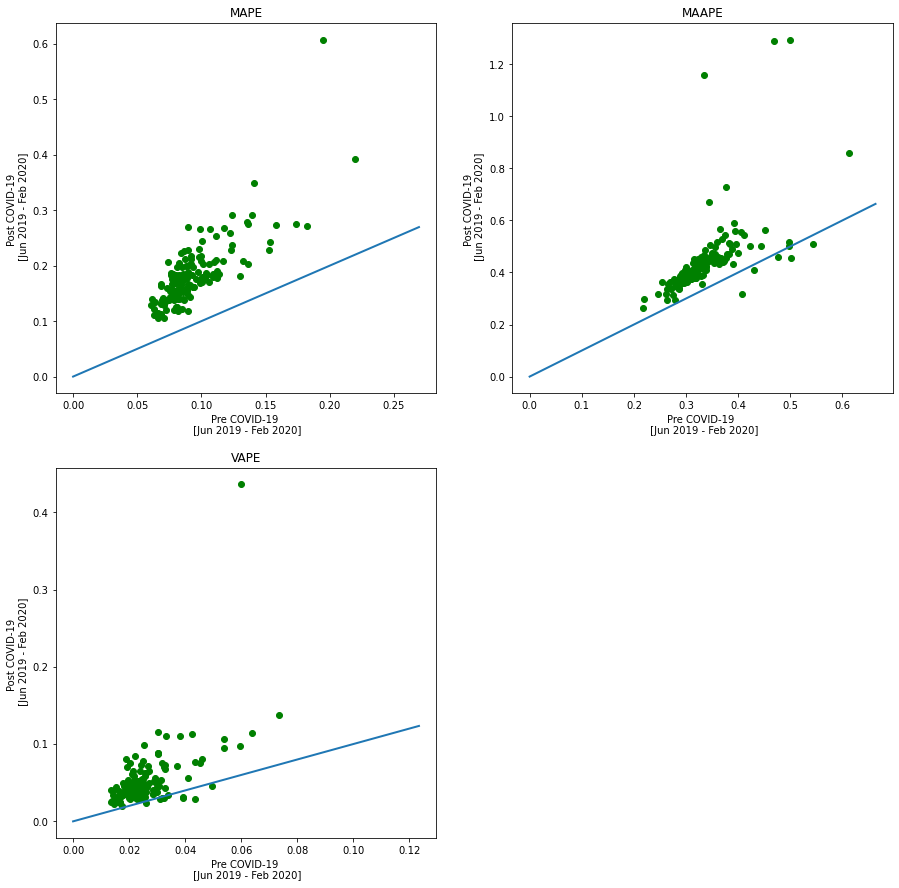

In [189]:
ols_results = linear_regression(df.dropna(), metrics)
print(ols_results.as_latex())
plot_results(df, metrics)


## Results Analysis 
To analyze the results, we do a linear regression (post-COVID as a function of pre-COVID). This is just a one variable regression, we can also do the plots. 

In [108]:
def linear_regression(results, metrics):

    models_list = []

    for metric in metrics: 
        pre_name = 'pre_' + metric
        post_name = 'post' + metric
        x = sm.add_constant(results[pre_name].rename('pre-COVID 19 metric'), prepend=False)
        model = sm.OLS(metrics[post_name], x)
        model_list.append(model)

    ols_results = summary_col(models_list,stars=True, info_dict = {"N":lambda x:(x.nobs)},
                              model_names = metrics, float_format='%.3f')

    return ols_results


    # x = sm.add_constant(metrics.pre_MAPE.rename('pre-COVID 19 metric'), prepend=False)
    # MAPE_model = sm.OLS(metrics.post_MAPE, x)
    # MAPE_res = MAPE_model .fit()

    # x = sm.add_constant(metrics.pre_MAAPE.rename('pre-COVID 19 metric'), prepend=False)
    # MAAPE_model = sm.OLS(metrics.post_MAAPE, x)
    # MAAPE_res = MAAPE_model .fit()

    # x = sm.add_constant(metrics.pre_VAPE.rename('pre-COVID 19 metric'), prepend=False)
    # VAPE_model = sm.OLS(metrics.post_VAPE, x)
    # VAPE_res = VAPE_model .fit()

    # x = sm.add_constant(metrics.pre_RMSE.rename('pre-COVID 19 metric'), prepend=False)
    # RMSE_model = sm.OLS(metrics.post_RMSE, x)
    # RMSE_res = RMSE_model .fit()

In [116]:
#Linear regressions

x = sm.add_constant(rnns.pre_MAPE.rename('pre-COVID 19 metric'), prepend=False)
MAPE_model = sm.OLS(rnns.post_MAPE, x)
MAPE_res = MAPE_model .fit()

x = sm.add_constant(rnns.pre_MAAPE.rename('pre-COVID 19 metric'), prepend=False)
MAAPE_model = sm.OLS(rnns.post_MAAPE, x)
MAAPE_res = MAAPE_model .fit()

x = sm.add_constant(rnns.pre_VAPE.rename('pre-COVID 19 metric'), prepend=False)
VAPE_model = sm.OLS(rnns.post_VAPE, x)
VAPE_res = VAPE_model .fit()

x = sm.add_constant(rnns.pre_RMSE.rename('pre-COVID 19 metric'), prepend=False)
RMSE_model = sm.OLS(rnns.post_RMSE, x)
RMSE_res = RMSE_model .fit()

In [117]:
models = [MAPE_res, MAAPE_res, VAPE_res, RMSE_res]
ols_results = summary_col(models,stars=True, 
                           info_dict = {"N":lambda x:(x.nobs)},
                           model_names = ['MAPE', 'MAAPE', 'VAPE', 'RMSE'],
                          float_format='%.3f')

In [118]:
print(ols_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                    & MAPE     & MAAPE    & VAPE     & RMSE        \\
\hline
pre-COVID 19 metric & 2.126*** & 1.058*** & 0.127*** & 1.108***    \\
                    & (0.194)  & (0.139)  & (0.014)  & (0.032)     \\
const               & -0.035   & 0.168**  & 1.188*** & -15.175***  \\
                    & (0.066)  & (0.068)  & (0.272)  & (3.390)     \\
R-squared           & 0.455    & 0.287    & 0.374    & 0.895       \\
R-squared Adj.      & 0.451    & 0.282    & 0.369    & 0.894       \\
N                   & 146.0000 & 146.0000 & 146.0000 & 146.0000    \\
\hline
\end{tabular}
\end{center}
\end{table}


In [133]:
#Linear regressions

x = sm.add_constant(rnns_non_transformed.pre_MAPE.rename('pre-COVID 19 metric'), prepend=False)
MAPE_model = sm.OLS(rnns_non_transformed.post_MAPE, x)
MAPE_res = MAPE_model .fit()

x = sm.add_constant(rnns_non_transformed.pre_MAAPE.rename('pre-COVID 19 metric'), prepend=False)
MAAPE_model = sm.OLS(rnns_non_transformed.post_MAAPE, x)
MAAPE_res = MAAPE_model .fit()

x = sm.add_constant(rnns_non_transformed.pre_VAPE.rename('pre-COVID 19 metric'), prepend=False)
VAPE_model = sm.OLS(rnns_non_transformed.post_VAPE, x)
VAPE_res = VAPE_model .fit()

x = sm.add_constant(rnns_non_transformed.pre_RMSE.rename('pre-COVID 19 metric'), prepend=False)
RMSE_model = sm.OLS(rnns_non_transformed.post_RMSE, x)
RMSE_res = RMSE_model .fit()

models = [MAPE_res, MAAPE_res, VAPE_res, RMSE_res]
ols_results = summary_col(models,stars=True, 
                           info_dict = {"N":lambda x:(x.nobs)},
                           model_names = ['MAPE', 'MAAPE', 'VAPE', 'RMSE'],
                          float_format='%.3f')

print(ols_results.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllll}
\hline
                    & MAPE     & MAAPE    & VAPE     & RMSE      \\
\hline
pre-COVID 19 metric & 1.849*** & 1.409*** & 2.213*** & 1.496***  \\
                    & (0.117)  & (0.156)  & (0.262)  & (0.110)   \\
const               & 0.010    & -0.032   & -0.005   & -0.038    \\
                    & (0.011)  & (0.054)  & (0.007)  & (0.051)   \\
R-squared           & 0.632    & 0.362    & 0.331    & 0.561     \\
R-squared Adj.      & 0.630    & 0.357    & 0.326    & 0.558     \\
N                   & 146.0000 & 146.0000 & 146.0000 & 146.0000  \\
\hline
\end{tabular}
\end{center}
\end{table}


# MAPE

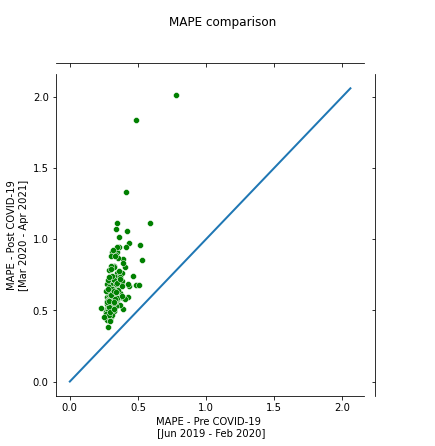

In [119]:
plot_1('pre_MAPE','post_MAPE',rnns, title = 'MAPE comparison', 
    xlabel = 'MAPE - Pre COVID-19 \n [Jun 2019 - Feb 2020]', 
    ylabel = 'MAPE - Post COVID-19\n[Mar 2020 - Apr 2021]')

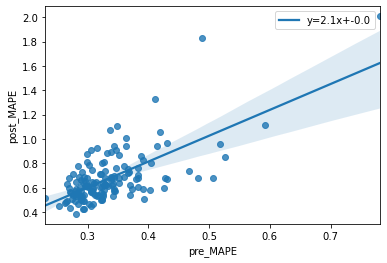

In [120]:
plot_2(x = 'pre_MAPE', y = 'post_MAPE', data = rnns)

# MAAPE

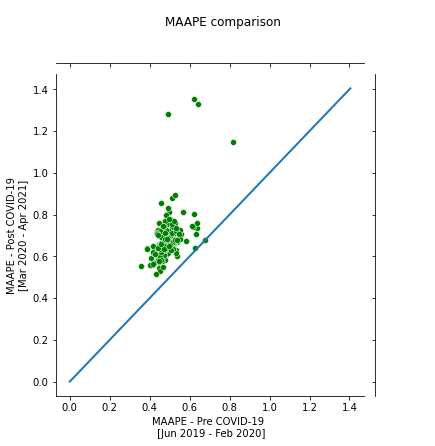

In [121]:
plot_1('pre_MAAPE','post_MAAPE',rnns, title = 'MAAPE comparison', 
    xlabel = 'MAAPE - Pre COVID-19 \n [Jun 2019 - Feb 2020]', 
    ylabel = 'MAAPE - Post COVID-19\n[Mar 2020 - Apr 2021]')

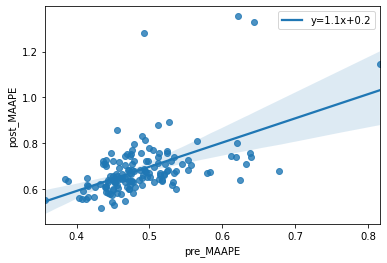

In [122]:
plot_2(x = 'pre_MAAPE', y = 'post_MAAPE', data = rnns)

# VAPE

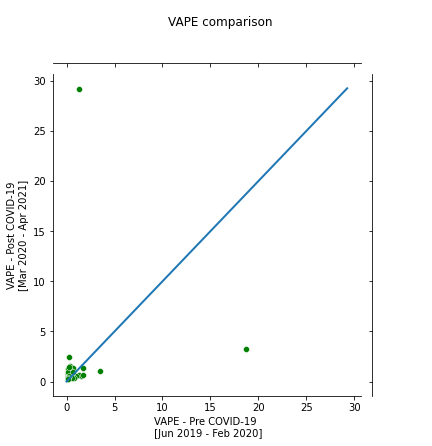

In [123]:
plot_1('pre_VAPE','post_VAPE',rnns[rnns.pre_MAPE < 0.3], title = 'VAPE comparison', 
    xlabel = 'VAPE - Pre COVID-19 \n [Jun 2019 - Feb 2020]', 
    ylabel = 'VAPE - Post COVID-19\n[Mar 2020 - Apr 2021]')

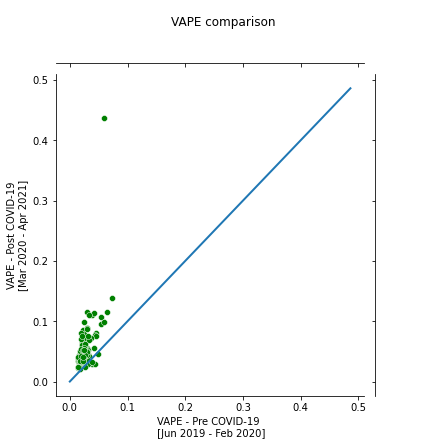

In [134]:
plot_1('pre_VAPE','post_VAPE',rnns_non_transformed, title = 'VAPE comparison', 
    xlabel = 'VAPE - Pre COVID-19 \n [Jun 2019 - Feb 2020]', 
    ylabel = 'VAPE - Post COVID-19\n[Mar 2020 - Apr 2021]')

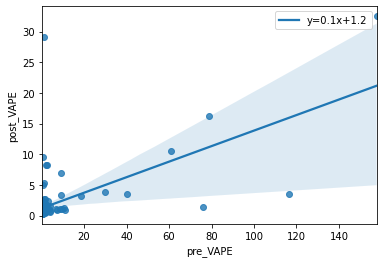

In [124]:
plot_2(x = 'pre_VAPE', y = 'post_VAPE', data = rnns)

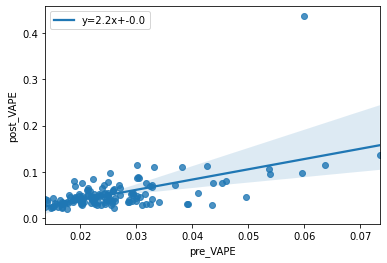

In [135]:
plot_2(x = 'pre_VAPE', y = 'post_VAPE', data = rnns_non_transformed)

# RMSE

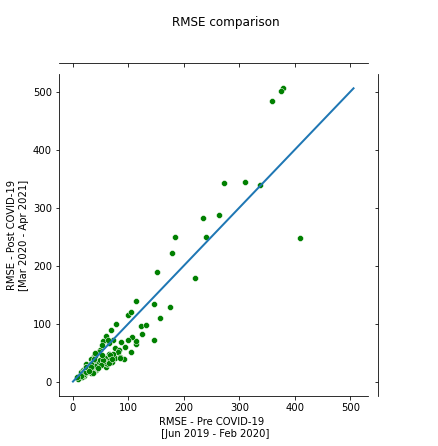

In [125]:
plot_1('pre_RMSE','post_RMSE',rnns, title = 'RMSE comparison', 
    xlabel = 'RMSE - Pre COVID-19 \n [Jun 2019 - Feb 2020]', 
    ylabel = 'RMSE - Post COVID-19\n[Mar 2020 - Apr 2021]')

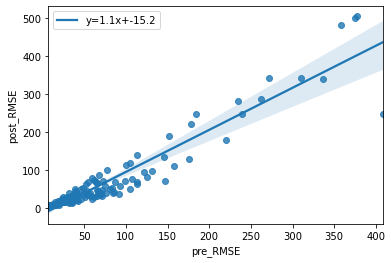

In [126]:
plot_2(x = 'pre_RMSE', y = 'post_RMSE', data = rnns)